<img src="Project Description.PNG" alt="Drawing" style="width: 800px;"/>

In [3]:
%pip install yfinance

In [70]:
import pandas as pd
import numpy as np
import random
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


size = 18
params = {'legend.fontsize': 'large',
          'figure.figsize': (15,8),
          'axes.labelsize': size * 0.8,
          'axes.titlesize': size * 0.95,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

### The GBM Model for STOXX50E simulation

[*********************100%***********************]  1 of 1 completed


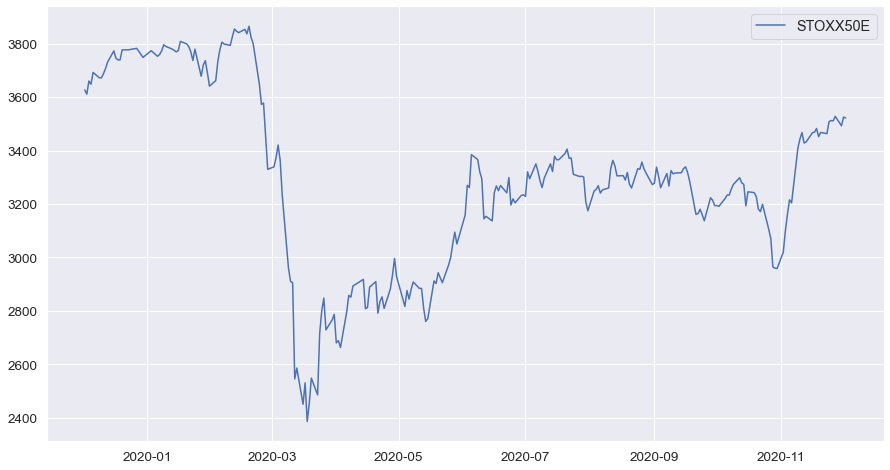

In [6]:
price = yf.download("^STOXX50E", start = "2019-12-01", end = "2020-12-3")['Adj Close'].reset_index()

plt.plot(price['Date'], price['Adj Close'], label = "STOXX50E")
plt.legend()
plt.show()


### Maximum Likelihood Estimator for Drift and Volatility of STOXX50E

In [7]:
n = len(price['Date'])
delta = 1
x_bar = np.sum(np.log(price['Adj Close']/price['Adj Close'].shift(1)))/n

print ("MLE for Drift parameter(μ) : " + str(x_bar))

MLE for Drift parameter(μ) : -0.0001169688553969635


In [8]:
price_bar = np.log(price['Adj Close']/price['Adj Close'].shift(1)) - x_bar
vol = np.sum(np.power(price_bar, 2))/n
vol = np.sqrt(vol)
print ("MLE for Volatility parameter(σ) : " + str(vol))

MLE for Volatility parameter(σ) : 0.020456189051262293


### Simulating Geometric Brownian Motion

90


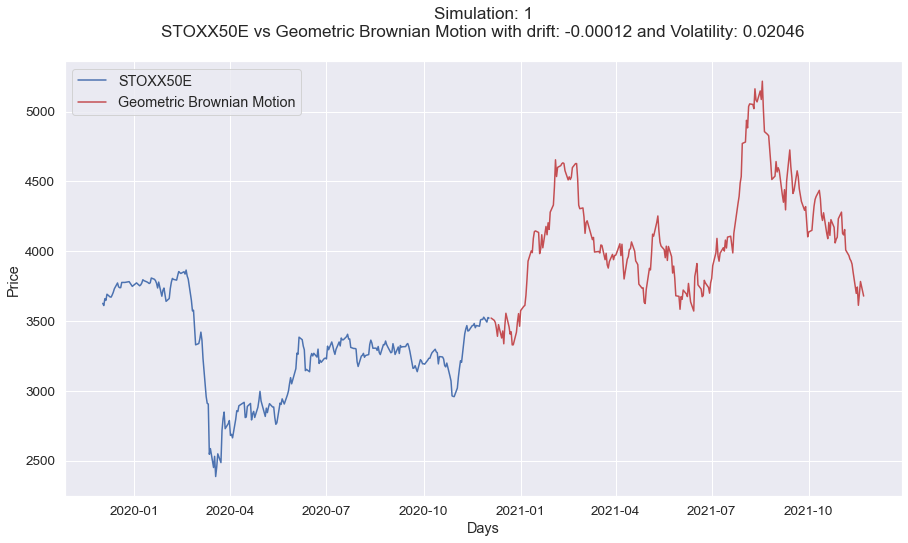

In [9]:
def Brownian(seed, N):
    
    np.random.seed(seed)                         
    dt = 1                                    # time step
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # brownian increments
    W = np.cumsum(b)                             # brownian path
    return W, b

seed =10
N  = n     # increments

seed_list = [90]
k = 1
for seed in seed_list:
    
    #print ("Simulation: " + str(k))
    print (seed)
    k += 1
    W = Brownian(seed, N)[0]
    W = np.insert(W, 0, 0.)  

    def GBM(So, mu, sigma, W, T, N):    
        t = np.ones((N + 1))
        S = []
        S.append(So)
        for i in range(1,int(N+1)):
            
            #drift = (mu - 0.5 * sigma**2) * t[i]
            drift = (mu) * t[i]
            diffusion = sigma * W[i-1]
            S_temp = So*np.exp(drift + diffusion)
            S.append(S_temp)
        return S, t

    So = price['Adj Close'].iloc[-1]
    mu = x_bar
    sigma = vol
    #pranav
    # mu = 0.2646
    # sigma = 0.247
    W = Brownian(seed, N)[0]
    T = 1.

    GBM_avg = np.zeros((1000, 252))

    for i in range(1000):
        soln = GBM(So, mu, sigma, W, T, N)[0]    # Exact solution
        soln = soln[:-1]
        GBM_avg[i] = soln
    gbm_avg = GBM_avg.mean(axis = 0)
    t = GBM(So, mu, sigma, W, T, N)[1]       # time increments for  plotting
    
    rng = pd.date_range('2020-12-4', periods=len(gbm_avg), freq='B')
    price_gbm = pd.DataFrame({ 'Date': rng, 'Close': gbm_avg}) 

    plt.title('Simulation: ' + str(k- 1) + '\nSTOXX50E vs Geometric Brownian Motion with drift: ' + str(round(mu, 5)) + " and Volatility: " + str(round(sigma, 5)))
    plt.plot(price['Date'], price['Adj Close'], label = "STOXX50E")
    plt.plot(price_gbm['Date'], price_gbm['Close'], color = 'r', label = "Geometric Brownian Motion")
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## The Vasicek Model for USD LIBOR rate simulation
dr(t) = k[θ − r(t)]dt + σdW(t)

In [231]:
def vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):    
    
    np.random.seed(seed)
    dt = T/float(N)    
    rates = [r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

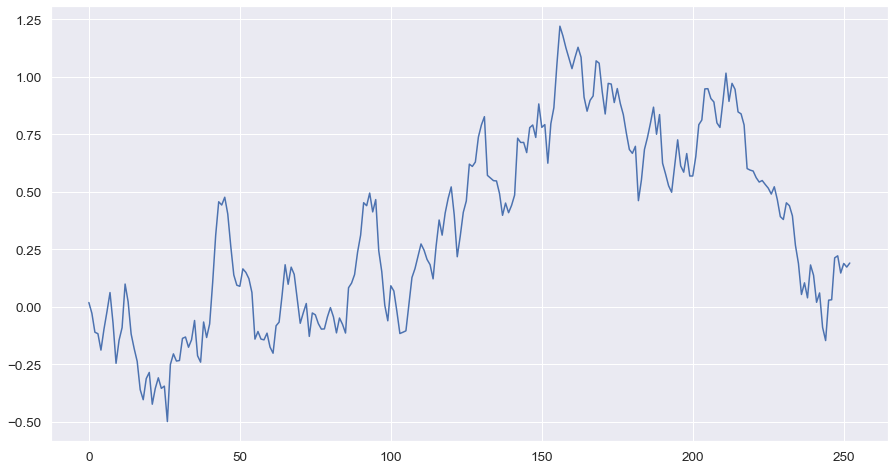

In [232]:
xo, yo = vasicek(0.01875, 0.20, 0.01, 0.1, 1, 252)

plt.plot(xo,yo)
plt.show()

### MLE ESTIMATOR FOR LIBOR 

In [233]:
df = pd.read_csv('LIBOR USD.csv')
df = df.drop(columns = ['Week day','ON','1W','1M','2M','6M','12M'])
#df.set_index('Date')

df['Date'] = df['Date'].astype('datetime64[ns]')
df = df.sort_values(by = ['Date'])
df.head()

,Date,3M
171,2020-01-04,1.43650
151,2020-01-05,0.54088
132,2020-01-06,0.33713
110,2020-01-07,0.29850
67,2020-01-09,0.25113


In [234]:
r = np.array(df['3M'])
r = r[1:]
a = r[:len(r)-1]

x = np.array(df['3M'])
b = x[:len(x)-1]


In [235]:
s0 = (np.sum(r) - r[-1]) / len(r)
s1 = np.mean(r)
s00 = np.sum(a**2) / len(r)
s01 = np.sum(b*r) / len(r)
s0,s1,s00,s01

(0.6772690212765957,
 0.6782094468085107,
 0.8165354139089362,
 0.7369625360093616)

In [236]:
rn = (s1*s00 - s0*s01) / ((s0*s1) - (s0**2) + (s00-s01))
rn

0.6814645664473323

In [243]:
# dt value needs to be verified -- IMP IMP IMP



k = np.log((s0-np.mean(x)) / (s1 - np.mean(x)) ) / 3  # Taking dt = 3
k

0.08557386957220882

In [244]:
beta = 1/k * (1 - np.exp(k))
beta

-1.0440339796274443

In [245]:
def B(s):
    return (1 - np.exp(-k))/k

x = np.array(df['3M'])
u = np.mean(x)
m = np.array([])

for i in range(1,len(x)):
    a = (u * k * B(k)) + (x[i-1] * (1- (k * B(k)))) 
    m = np.append(m,a)


In [246]:
sig = 1/((len(x)*beta)*(1 - k*beta/2)) * np.sum((r - m)**2)
sig

-0.14300039280155663

In [247]:
xu, yu = vasicek(rn, k, 0.1, sig, 1, 252)
yn = np.append(yo[-1],yu)
xn = np.append(xo[-1],xu)

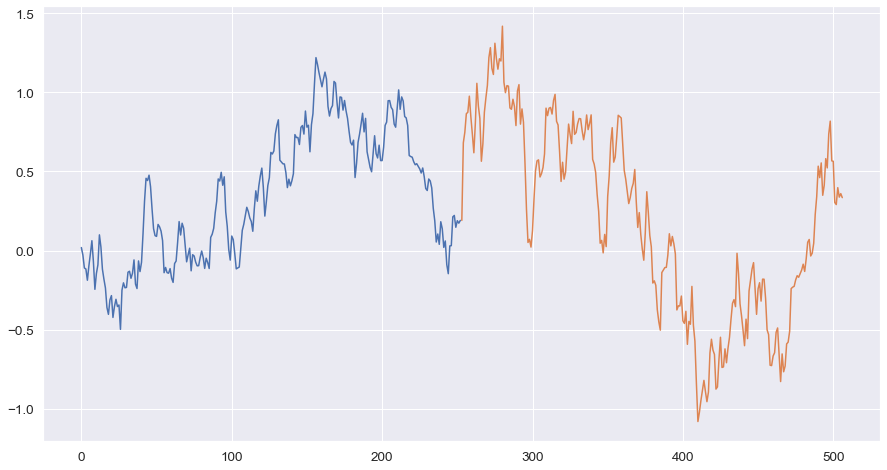

In [248]:
plt.plot(xo,yo)
plt.plot(range(len(xo),len(xu) + len(xo)+1),yn)

plt.show()